This code looks for evidence of bunching in the auctions

In [182]:
%reset -f

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import numpy as np
from pandasgui import show

In [194]:
username = socket.gethostname()
if username == 'lucas':
    root_path = r'C:\Users\lucas\OneDrive - Yale University\Documents\GitHub\2nd-year-paper'

base_path = os.path.join(root_path,'raw_data','CM cars auction')
print(os.path.abspath(base_path))


base_dir = os.path.expanduser("~")  # Gets the user's home directory
output_path = os.path.join(base_dir, "Dropbox", "Apps", "Overleaf", "Second year paper", "figures", "bunching")
print(os.path.abspath(output_path))

if not os.path.exists(output_path):
    os.makedirs(output_path)


C:\Users\lucas\OneDrive - Yale University\Documents\GitHub\2nd-year-paper\raw_data\CM cars auction
C:\Users\lucas\Dropbox\Apps\Overleaf\Second year paper\figures\bunching


# Prepare data

Read the files

In [184]:
#paths 
path_prices_17 = os.path.join(base_path, 'Planilla_General_Evaluación_-_ID_2239-4-LR17_(Publicación).xlsx')
path_prices_21 = os.path.join(base_path, 'Planilla_de_adjudicación_CM_Vehículos_ID_2239-5-LR21_V.F..xlsx')
path_prices_23 = os.path.join(base_path, 'PROVEEDORES_-_Evaluación_CM_Vehículos_y_maquinarias.xlsx')

#2017 files
aux1 = pd.read_excel(path_prices_17, sheet_name = 'Ev_Compra_Subcat1+2')
aux1['auction_id'] = 1 
aux2 = pd.read_excel(path_prices_17, sheet_name = 'Ev_Compra_Subcat3')
aux2['auction_id'] = 2 
aux3 = pd.read_excel(path_prices_17, sheet_name = 'Ev_Compra_Subcat4')
aux3['auction_id'] = 3


#2021 files
aux4 = pd.read_excel(path_prices_21, sheet_name = 6)
aux4['auction_id'] = 4 
aux5 = pd.read_excel(path_prices_21, sheet_name = 7)
aux5['auction_id'] = 5

#2023 files: has only one sheet 
auction_23 = pd.read_excel(path_prices_23, sheet_name = 2, skiprows = 2)


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed



concatenate for each year and drop bids that were not considered (the bid was not filled properly)

In [185]:
#2017 
auction_17 = pd.concat([aux1, aux2, aux3], ignore_index=True)
auction_17 = auction_17[auction_17['Situación Final por Marca']!= 'Desestimada']
auction_17 = auction_17[auction_17['Puntaje Final Marca']!= 'Desestimada']
auction_17['Year'] = 2017

#2021
auction_21 = pd.concat([aux4, aux5], ignore_index=True)
auction_21['Year'] = 2021
auction_21 = auction_21[auction_21['Estado Anterior'] == 'ADMISIBLE']
auction_21 = auction_21[auction_21['Estado Final'] != 'INADMISIBLE']

#2023 only one spreadsheet
auction_23['Year'] = 2023
#print(auction_23['ADMISIBILIDAD OFERTA PREVIO EV. ECO'].value_counts())
auction_23 = auction_23[auction_23['ADMISIBILIDAD OFERTA PREVIO EV. ECO'] == 'Admisible']

create auction_id for 2023 where all the auctions are in one sheet. 

In [186]:
# Create a unique ID by combining 'Tipo Producto' and 'Region N'
auction_23['auction_id'] = auction_23.groupby(['Tipo Producto', 'Región N°']).ngroup()
auction_23['auction_id'] = auction_23['auction_id']+6 #the other auctions have id from 1 to 5

Rename columns to make them coincide with 2017 files. 

In [187]:
rename_dict = {
    #for 2017 
    'Puntaje Final Marca': 'score',
    #for 2021
    'Estado Final':  'Estado Final Marca',
    'PUNTAJE OFERTA': 'score',  
    #for 2023
    'Adjudicación final (regla mín 5 reg y 10 RM)': 'Estado Final Marca',
    'Puntaje Total': 'score',
}
auction_17.rename(columns=rename_dict, inplace=True)

auction_21.rename(columns=rename_dict, inplace=True)
auction_21['Situación Final por Marca'] = ''

auction_23.rename(columns=rename_dict, inplace=True)
auction_23['Situación Final por Marca'] = ''

concatenate

In [188]:
final_df = pd.concat([auction_17, auction_21, auction_23], ignore_index=True)

var_list = ['score', 'Estado Final Marca', 'auction_id', 'Year']

final_df = final_df[var_list]


create thresholds

In [189]:
print(final_df['Estado Final Marca'].value_counts())

final_df['Estado Final Marca'] = final_df['Estado Final Marca'].str.replace('ADJUDICA', 'Adjudica')

thresholds_df = (
    final_df
    .loc[final_df["Estado Final Marca"] == "Adjudica"]
    .groupby("auction_id")["score"]
    .min()
    .reset_index(name="auction_threshold")
)
final_df = final_df.merge(thresholds_df, on="auction_id", how="left")
print(final_df.shape)


Estado Final Marca
Adjudica       3021
No Adjudica    1448
ADJUDICA         97
Name: count, dtype: int64
(4566, 5)


In [190]:
final_df['normalized_score'] = final_df['score'] / final_df['auction_threshold'] - 1
summary = final_df['normalized_score'].describe()
print(summary)

count     4566.0
unique    1580.0
top          0.0
freq       544.0
Name: normalized_score, dtype: float64


In [191]:
show(final_df)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [192]:
# Check if all values in the 'score' column are numeric
is_numeric = pd.to_numeric(final_df['score'], errors='coerce').notna().all()

if is_numeric:
    print("The 'score' column contains only numeric values.")
else:
    print("The 'score' column contains non-numeric values.")

# Optionally, print rows with non-numeric values in the 'score' column
non_numeric_rows = final_df[pd.to_numeric(final_df['score'], errors='coerce').isna()]
if not non_numeric_rows.empty:
    print("Rows with non-numeric values in the 'score' column:")
    print(non_numeric_rows)


The 'score' column contains only numeric values.


# use the data

In [196]:
average_observations = final_df.groupby('auction_id').size().mean()
print(f'Average number of observations by auction_id: {average_observations}')

Average number of observations by auction_id: 23.17766497461929


In [197]:
summary = thresholds_df['auction_threshold'].describe()
threshold_counts = thresholds_df['auction_threshold'].value_counts().sort_index()

print("Threshold Summary:")
print(summary)
print("\nMost common threshold values:")
print(threshold_counts.head())

Threshold Summary:
count     197.0
unique     68.0
top        50.0
freq       40.0
Name: auction_threshold, dtype: float64

Most common threshold values:
auction_threshold
35.0                  2
38.566878980891715    1
43.859344894026975    1
48.20882352941177     1
49.88404452690167     1
Name: count, dtype: int64


In [198]:
bin_range = 0.05 
lower_bound = -0.6 
upper_bound = 0.6 + bin_range
bin_edges = np.round(np.arange(lower_bound, upper_bound, bin_range), 2)  # round to 2 decimals
final_df["bin"] = pd.cut(
    final_df["normalized_score"],
    bins=bin_edges,
    include_lowest=True,
    right=True  # or False, depending on how you want the bins to be closed
)

bin_counts = final_df["bin"].value_counts().sort_index()
print(bin_counts)              # See what intervals actually got created
print(bin_counts.index.tolist())  # List them out

bin
(-0.601, -0.55]      0
(-0.55, -0.5]       27
(-0.5, -0.45]        5
(-0.45, -0.4]       17
(-0.4, -0.35]       44
(-0.35, -0.3]       49
(-0.3, -0.25]       53
(-0.25, -0.2]       95
(-0.2, -0.15]      101
(-0.15, -0.1]      107
(-0.1, -0.05]      139
(-0.05, 0.0]       675
(0.0, 0.05]        188
(0.05, 0.1]        244
(0.1, 0.15]        260
(0.15, 0.2]        242
(0.2, 0.25]        416
(0.25, 0.3]        219
(0.3, 0.35]        239
(0.35, 0.4]        212
(0.4, 0.45]        206
(0.45, 0.5]        178
(0.5, 0.55]         52
(0.55, 0.6]         28
Name: count, dtype: int64
[Interval(-0.601, -0.55, closed='right'), Interval(-0.55, -0.5, closed='right'), Interval(-0.5, -0.45, closed='right'), Interval(-0.45, -0.4, closed='right'), Interval(-0.4, -0.35, closed='right'), Interval(-0.35, -0.3, closed='right'), Interval(-0.3, -0.25, closed='right'), Interval(-0.25, -0.2, closed='right'), Interval(-0.2, -0.15, closed='right'), Interval(-0.15, -0.1, closed='right'), Interval(-0.1, -0.05, clo

In [199]:
# if auction_threshold was 100 then kind of 'artificially' we had many obs just below the threshold. 
aux_df  = final_df[final_df['auction_threshold']< 100]
print(len(final_df['auction_id'].unique()))
print(len(aux_df['auction_id'].unique()))

# if auction_threshold was 100 then kind of 'artificially' we had many obs just below the threshold. 
aux_df2  = aux_df[aux_df['normalized_score'] != 0]
print(aux_df.shape, aux_df2.shape)

#drop auctions were all the bids were selected 
all_adjudica_mask = aux_df2.groupby("auction_id")["Estado Final Marca"] \
                      .transform(lambda x: x.eq("Adjudica").all())

# Keep only the rows that are NOT all Adjudica
aux_df2 = aux_df2[~all_adjudica_mask]
print(aux_df2.shape)

197
173
(4178, 7) (3887, 7)
(3635, 7)


In [200]:
bin_counts = aux_df2["bin"].value_counts().sort_index()
print(bin_counts)              # See what intervals actually got created
print(bin_counts.index.tolist())  # List them out

bin
(-0.601, -0.55]      0
(-0.55, -0.5]        2
(-0.5, -0.45]        4
(-0.45, -0.4]       14
(-0.4, -0.35]       28
(-0.35, -0.3]       43
(-0.3, -0.25]       50
(-0.25, -0.2]       79
(-0.2, -0.15]       85
(-0.15, -0.1]       91
(-0.1, -0.05]      130
(-0.05, 0.0]       112
(0.0, 0.05]        175
(0.05, 0.1]        221
(0.1, 0.15]        253
(0.15, 0.2]        228
(0.2, 0.25]        384
(0.25, 0.3]        201
(0.3, 0.35]        171
(0.35, 0.4]        201
(0.4, 0.45]        200
(0.45, 0.5]        176
(0.5, 0.55]         52
(0.55, 0.6]         28
Name: count, dtype: int64
[Interval(-0.601, -0.55, closed='right'), Interval(-0.55, -0.5, closed='right'), Interval(-0.5, -0.45, closed='right'), Interval(-0.45, -0.4, closed='right'), Interval(-0.4, -0.35, closed='right'), Interval(-0.35, -0.3, closed='right'), Interval(-0.3, -0.25, closed='right'), Interval(-0.25, -0.2, closed='right'), Interval(-0.2, -0.15, closed='right'), Interval(-0.15, -0.1, closed='right'), Interval(-0.1, -0.05, clo

## Formal test 

In [201]:
aux_df2["score"] = pd.to_numeric(aux_df2["score"])
aux_df2["auction_threshold"] = pd.to_numeric(aux_df2["auction_threshold"])
aux_df2["normalized_score"] = pd.to_numeric(aux_df2["normalized_score"])

print(aux_df2.dtypes)

score                  float64
Estado Final Marca      object
auction_id               int64
Year                     int64
auction_threshold      float64
normalized_score       float64
bin                   category
dtype: object


In [202]:
# 1) Split left vs. right
df_left = aux_df2[aux_df2["normalized_score"] < 0].copy()
df_right = aux_df2[aux_df2["normalized_score"] >= 0].copy()

# 2) Fit separate quadratics
#    outcome ~ x + x^2
import statsmodels.formula.api as smf

model_left = smf.ols(
    formula="score ~ normalized_score + I(normalized_score**2)", 
    data=df_left
).fit()

model_right = smf.ols(
    formula="score ~ normalized_score + I(normalized_score**2)", 
    data=df_right
).fit()

# 3) Predict each model at x=0
pred_left_at0 = model_left.predict({"normalized_score": 0})
pred_right_at0 = model_right.predict({"normalized_score": 0})

jump_estimate = float(pred_right_at0 - pred_left_at0)
print("Estimated jump at 0:", jump_estimate)

# 4) A quick "test" is to see if CIs for those predictions overlap
#    (properly you'd do a joint or delta-method test).
left_conf = model_left.get_prediction({"normalized_score": 0}).conf_int()
right_conf = model_right.get_prediction({"normalized_score": 0}).conf_int()

print("Left side @ 0,  95% CI:", left_conf[0])
print("Right side @ 0, 95% CI:", right_conf[0])

# If those intervals do not overlap, you have evidence of a jump.


Estimated jump at 0: 6.97001009488784
Left side @ 0,  95% CI: [71.81272813 75.07358348]
Right side @ 0, 95% CI: [79.49683488 81.32949691]


C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\2046524830.py:23: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



In [203]:
# Make sure df has columns:
#   - "score": the outcome
#   - "normalized_score": the running variable
aux_df2["D"] = (aux_df2["normalized_score"] >= 0).astype(int)

model = smf.ols(
    formula="""
        score 
        ~ normalized_score 
          + I(normalized_score**2)
          + D
          + D:normalized_score
          + D:I(normalized_score**2)
    """,
    data=aux_df2
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     864.3
Date:                Tue, 31 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:34:00   Log-Likelihood:                -13825.
No. Observations:                3635   AIC:                         2.766e+04
Df Residuals:                    3629   BIC:                         2.770e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## Plots

### Histograms

In [210]:
show(final_df)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


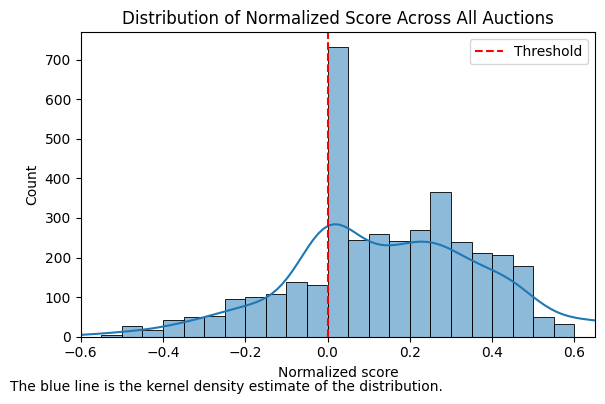

In [221]:
bin_edges = np.arange(lower_bound, upper_bound, bin_range)  # Ends at 0.71 to include 0.7
bin_edges = np.round(bin_edges, 2)  # Round to avoid floating point issues

plt.figure(figsize=(6, 4))
sns.histplot(
    data=final_df,
    x="normalized_score",
    bins=bin_edges, # one can also specify the number of bins e.g. replace bin_edges with 20
    #hue="Estado Final Marca",
    multiple="stack", 
    kde=True, # add a kernel density estimate
)
plt.axvline(x=0, color="red", linestyle="--", label="Threshold")
plt.xlim(lower_bound, upper_bound) # set the values for x-axis
plt.title("Distribution of Normalized Score Across All Auctions")
plt.xlabel("Normalized score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.figtext(0.0, 0.01, 'The blue line is the kernel density estimate of the distribution.')
plt.savefig(os.path.join(output_path, 'histogram_normalizedscore_kernel.png'))
plt.show()

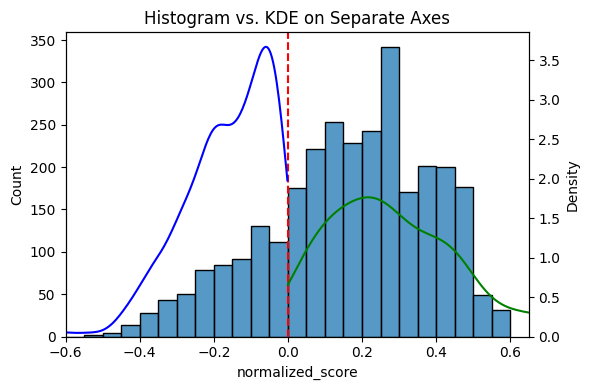

In [224]:
fig, ax1 = plt.subplots(figsize=(6, 4))

# 1) Primary axis: histogram
sns.histplot(
    data=aux_df2,
    x="normalized_score",
    bins=bin_edges,
    #hue="Estado Final Marca",
    multiple="stack",
    kde=False,
    ax=ax1 )
ax1.set_xlabel("normalized_score")
ax1.set_ylabel("Count")

# 2) Secondary axis: KDE (over entire dataset, ignoring hue)
ax2 = ax1.twinx()  # create a second y-axis sharing the same x-axis
sns.kdeplot(
    data=aux_df2[aux_df2["normalized_score"] < 0],
    x="normalized_score",
    color="blue",
    label="KDE (below 0)",
    cut=0  # optional, to limit the range of the kernel
)
sns.kdeplot(
    data=aux_df2[aux_df2["normalized_score"] >= 0],
    x="normalized_score",
    color="green",
    label="KDE (above 0)",
    cut=0 )
ax2.set_ylabel("Density")

ax1.axvline(x=0, color="red", linestyle="--", label="Threshold = 0")


plt.title("Histogram vs. KDE on Separate Axes")
plt.xlim(lower_bound, upper_bound)
plt.tight_layout()
#plt.figtext(0.0, 0.01, 'The blue line is the kernel density estimate of the distribution.')
plt.savefig(os.path.join(output_path, 'histogram_normalizedscore_kernel_notscaled.png'))
plt.show()

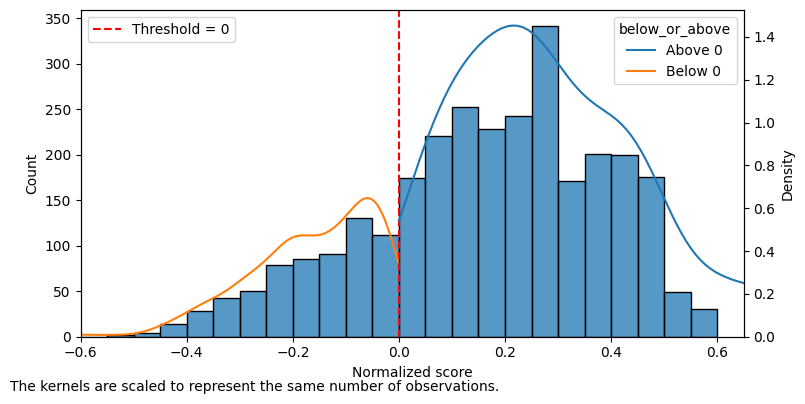

In [229]:
# 2) Mark each row as "Below 0" or "Above 0"
aux_df2["below_or_above"] = np.where(
    aux_df2["normalized_score"] < 0, 
    "Below 0", 
    "Above 0")

# 3) Create a figure + primary axis (histogram)
fig, ax1 = plt.subplots(figsize=(8, 4))

sns.histplot(
    data=aux_df2,
    x="normalized_score",
    bins=bin_edges,
    #hue="Estado Final Marca",  # Stacked by "Estado Final Marca"
    multiple="stack",
    kde=False,
    ax=ax1
)
ax1.set_xlabel("Normalized score")
ax1.set_ylabel("Count")

# 4) Secondary axis (single kdeplot with hue)
ax2 = ax1.twinx()

sns.kdeplot(
    data=aux_df2,
    x="normalized_score",
    hue="below_or_above",      # 2 lines: below 0 vs above 0
    common_norm=True,          # both subsets share total area = 1
    multiple="layer",          # show lines overlapping
    fill=False,                # just lines, no fill
    cut=0,
    ax=ax2
)
ax2.set_ylabel("Density")

# 5) Add vertical line at 0, merge legends, finalize
ax1.axvline(x=0, color="red", linestyle="--", label="Threshold = 0")

# Merge legends from both axes
lines_labels_1 = ax1.get_legend_handles_labels()
lines_labels_2 = ax2.get_legend_handles_labels()

# lines_labels_1/2 might have duplicates or partial info;
# often you may just keep them separate or simplify
handles = lines_labels_1[0] + lines_labels_2[0]
labels  = lines_labels_1[1] + lines_labels_2[1]
ax1.legend(handles, labels, loc="upper left")

#plt.title("Histogram (Stacked) + Single KDE with common_norm=True")
plt.xlim(lower_bound, upper_bound)
plt.tight_layout()
plt.figtext(0.0, 0.01, 'The kernels are scaled to represent the same number of observations.')
plt.savefig(os.path.join(output_path, 'histogram_normalizedscore_kernel_scaled.png'))
plt.show()

### Plots for all auctions using 'score' 

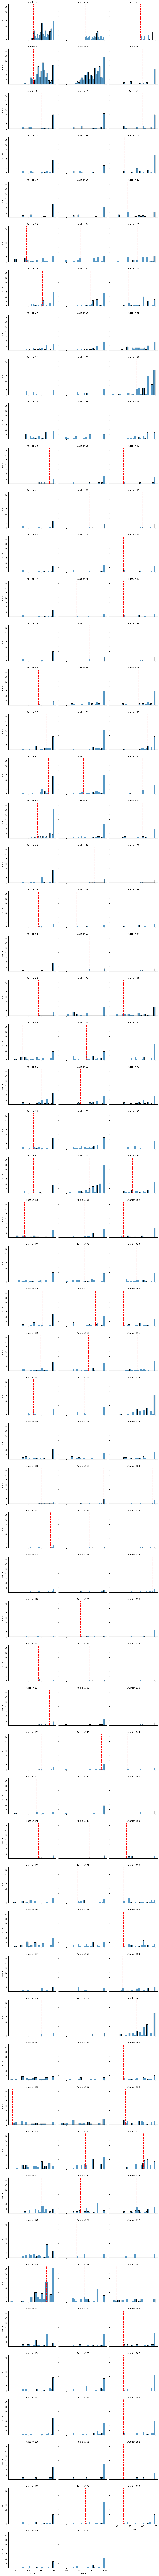

In [231]:
g = sns.FacetGrid(aux_df, col="auction_id", col_wrap=3, height=3, aspect=1.2)
g.map_dataframe(sns.histplot, x="score", bins=20)
g.set_titles("Auction {col_name}")
# Add a vertical line for the threshold per facet
for ax, auction_id in zip(g.axes.flatten(), g.col_names):
    # For each subplot, we get that auction's threshold:
    t = thresholds_df.loc[thresholds_df["auction_id"] == auction_id, "auction_threshold"]
    if not t.empty:
        ax.axvline(t.iloc[0], color="red", linestyle="--")

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'all_auction_score_histogram.png'))
plt.show()


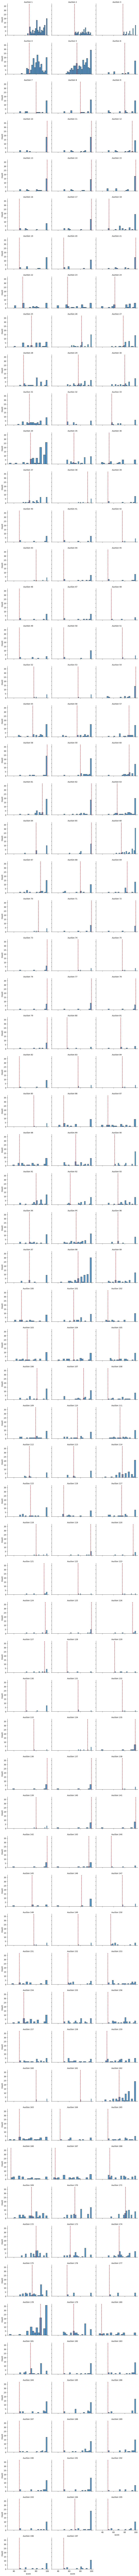

In [ ]:
g = sns.FacetGrid(final_df, col="auction_id", col_wrap=3, height=3, aspect=1.2)
g.map_dataframe(sns.histplot, x="score", bins=20)
g.set_titles("Auction {col_name}")
# Add a vertical line for the threshold per facet
for ax, auction_id in zip(g.axes.flatten(), g.col_names):
    # For each subplot, we get that auction's threshold:
    t = thresholds_df.loc[thresholds_df["auction_id"] == auction_id, "auction_threshold"]
    if not t.empty:
        ax.axvline(t.iloc[0], color="red", linestyle="--")

plt.tight_layout()
plt.savefig(os.path.join(output_path, '20_auctions_score_histogram.png'))

plt.show()


### using normalized score

C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\3849456411.py:41: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



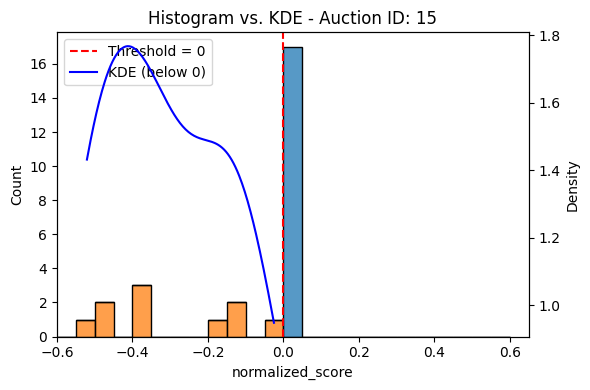

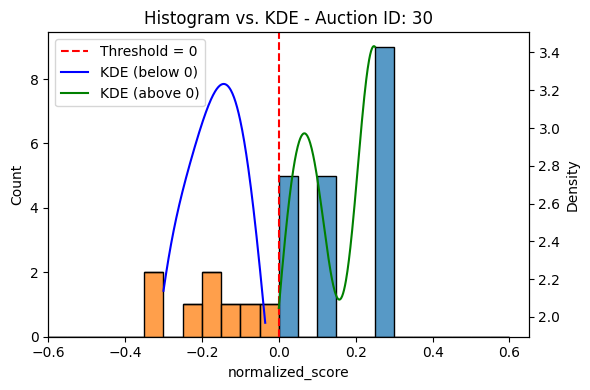

C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\3849456411.py:32: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



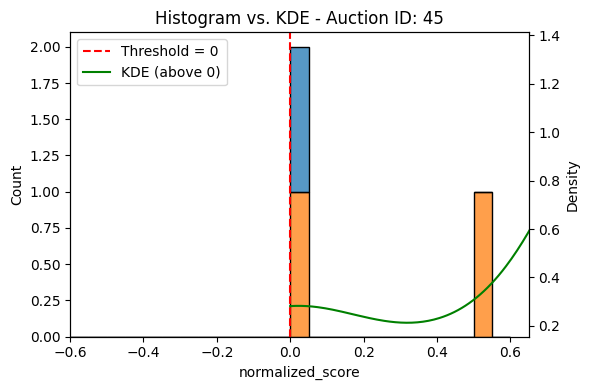

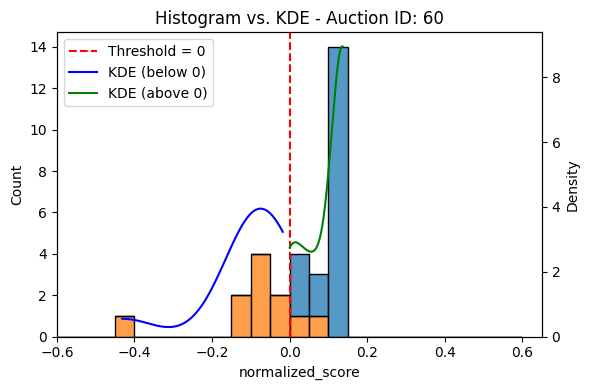

C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\3849456411.py:32: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



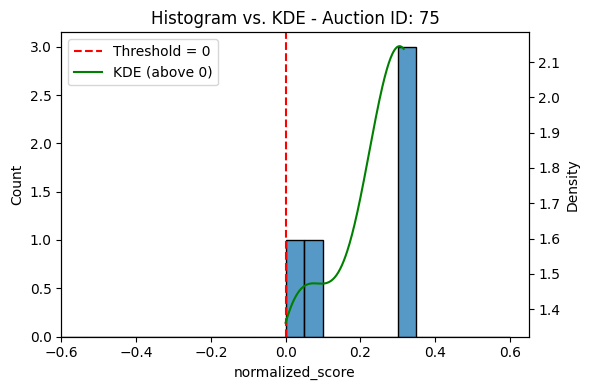

C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\3849456411.py:32: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



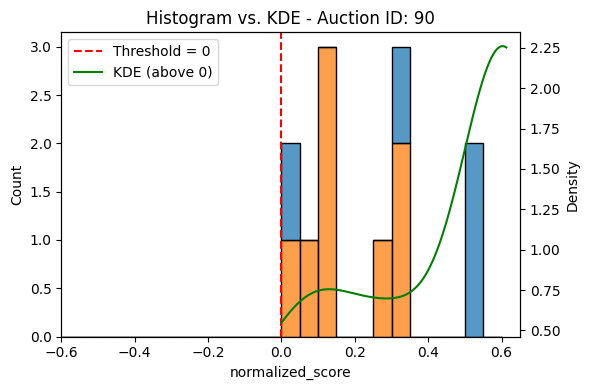

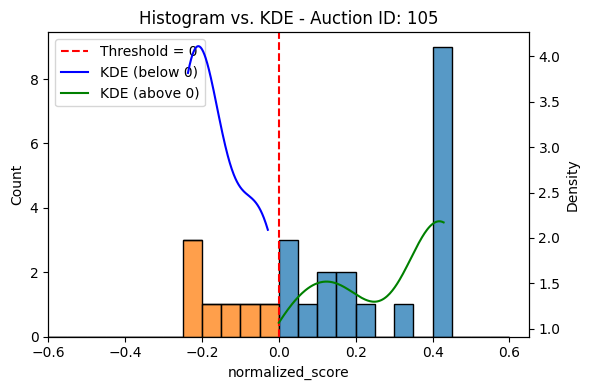

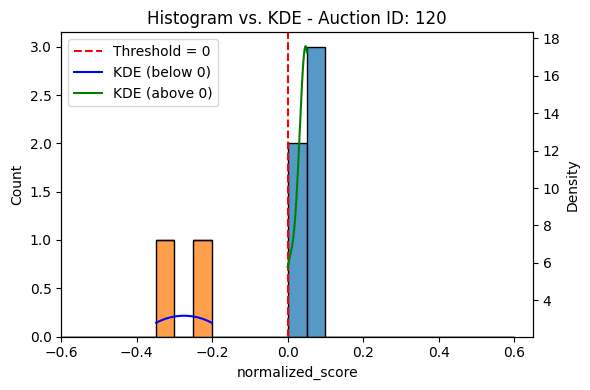

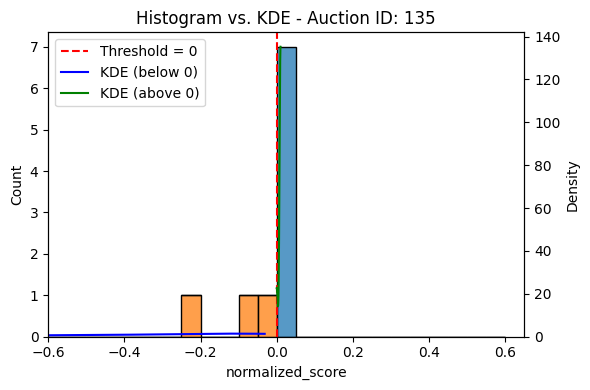

C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\3849456411.py:32: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



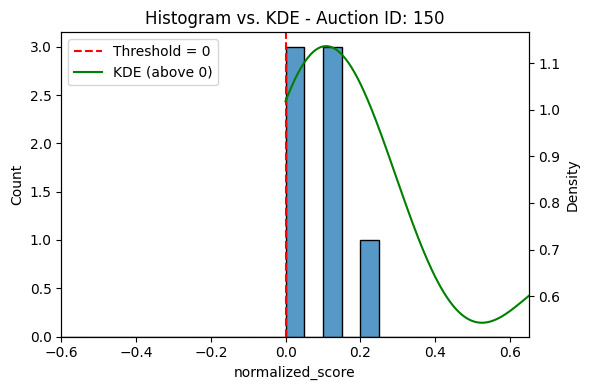

C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\3849456411.py:32: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



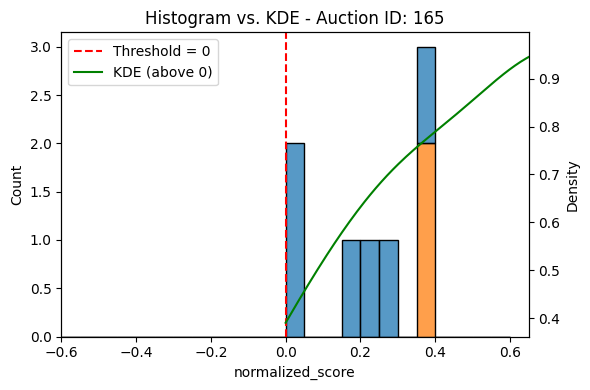

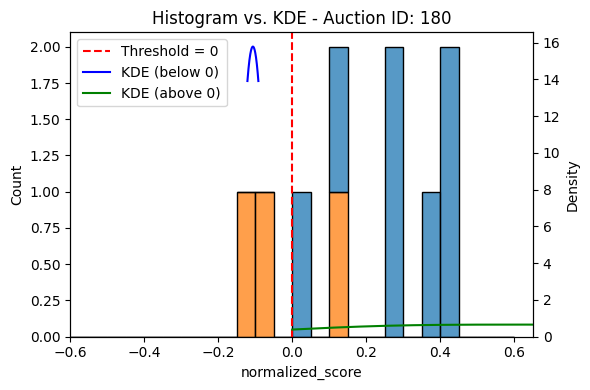

C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\3849456411.py:32: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



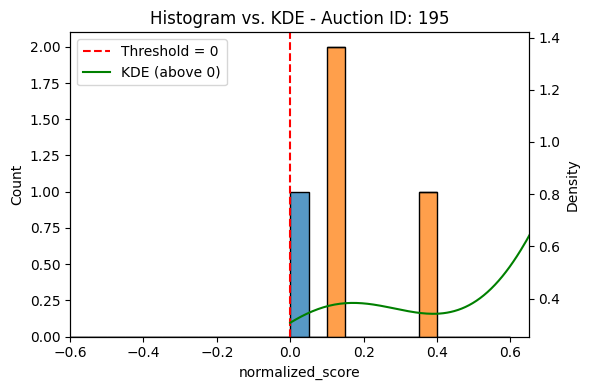

In [232]:
auction_ids = final_df['auction_id'].unique()
auction_ids_selected = auction_ids[auction_ids % 15 == 0]

for aid in auction_ids_selected:
    # Subset for this specific auction
    df_sub = final_df[final_df["auction_id"] == aid]
    
    # If there's not enough data, you might skip plotting
    if df_sub.empty:
        continue
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(6, 4))
    
    # 1) Primary axis: histogram
    sns.histplot(
        data=df_sub,
        x="normalized_score",
        bins=bin_edges,
        hue="Estado Final Marca",
        multiple="stack",
        kde=False,
        ax=ax1
    )
    ax1.set_xlabel("normalized_score")
    ax1.set_ylabel("Count")

    # 2) Secondary axis: two KDEs
    ax2 = ax1.twinx()
    
    # Below 0
    sns.kdeplot(
        data=df_sub[df_sub["normalized_score"] < 0],
        x="normalized_score",
        color="blue",
        label="KDE (below 0)",
        ax=ax2,
        cut=0
    )
    # Above or equal to 0
    sns.kdeplot(
        data=df_sub[df_sub["normalized_score"] >= 0],
        x="normalized_score",
        color="green",
        label="KDE (above 0)",
        ax=ax2,
        cut=0
    )
    
    ax2.set_ylabel("Density")
    
    # Vertical line at 0
    ax1.axvline(x=0, color="red", linestyle="--", label="Threshold = 0")
    
    # Merge legends (from both axes)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")
    
    # Set title to reflect current auction_id
    ax1.set_title(f"Histogram vs. KDE - Auction ID: {aid}")
    
    ax1.set_xlim(lower_bound, upper_bound)
    plt.tight_layout()
    
    plt.show()  # if you want to display it directly
    # plt.savefig(f"auction_{aid}.png") 
    plt.close(fig)  # Good practice to close the figure in a loop

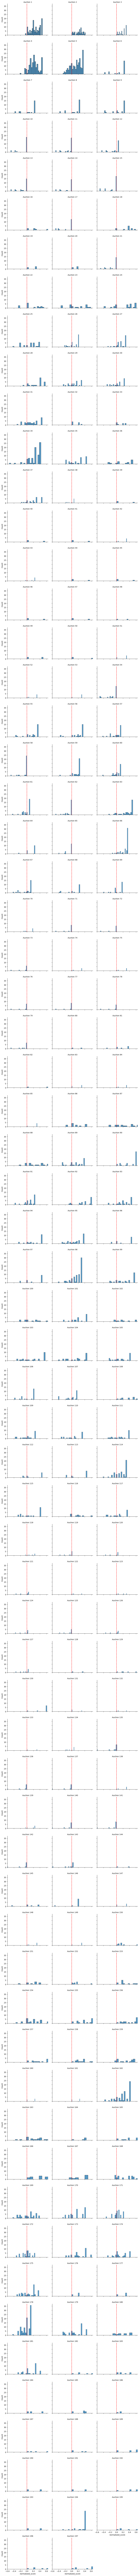

In [234]:
g = sns.FacetGrid(final_df, col="auction_id", col_wrap=3, height=3, aspect=1.2)
g.map_dataframe(sns.histplot, x="normalized_score", bins=20)
g.set_titles("Auction {col_name}")
g.set(xlim=(lower_bound, upper_bound))  # Set xlim for all plots

# Add a vertical line for the threshold per facet
for ax, auction_id in zip(g.axes.flatten(), g.col_names):
    ax.axvline(0, color="red", linestyle="--")


plt.tight_layout()
plt.savefig(os.path.join(output_path, 'all_auction_normalizedscore_histogram.png'))

plt.show()


C:\Users\lucas\AppData\Local\Temp\ipykernel_15696\1973498698.py:5: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



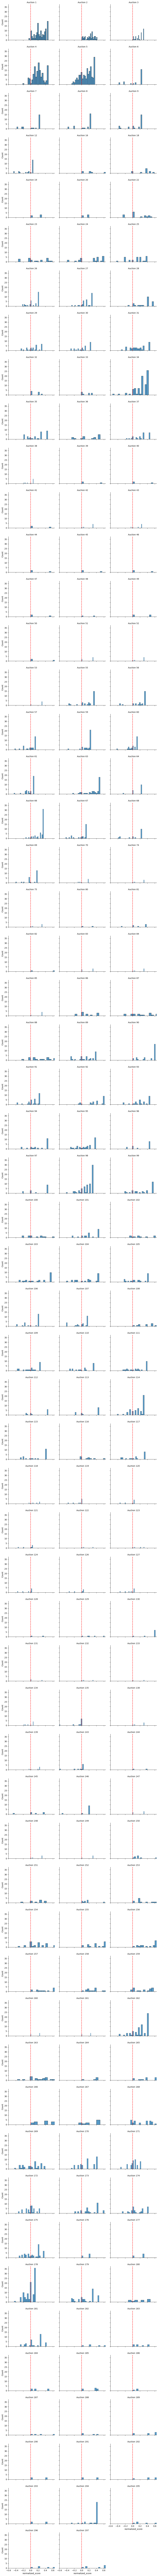

In [235]:
g = sns.FacetGrid(aux_df, col="auction_id", col_wrap=3, height=3, aspect=1.2)
g.map_dataframe(sns.histplot, x="normalized_score", bins=20)
g.set_titles("Auction {col_name}")

g.axes.flat[0].get_shared_x_axes().join(*g.axes.flat)  # Share x-axis across all plots
g.set(xlim=(lower_bound, upper_bound))  # Set xlim for all plots
g.refline(x=0, color="red", linestyle="--")  # Add vertical line to all plots
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'competitiveauctions_normalizedscore_histogram.png'))

plt.show()

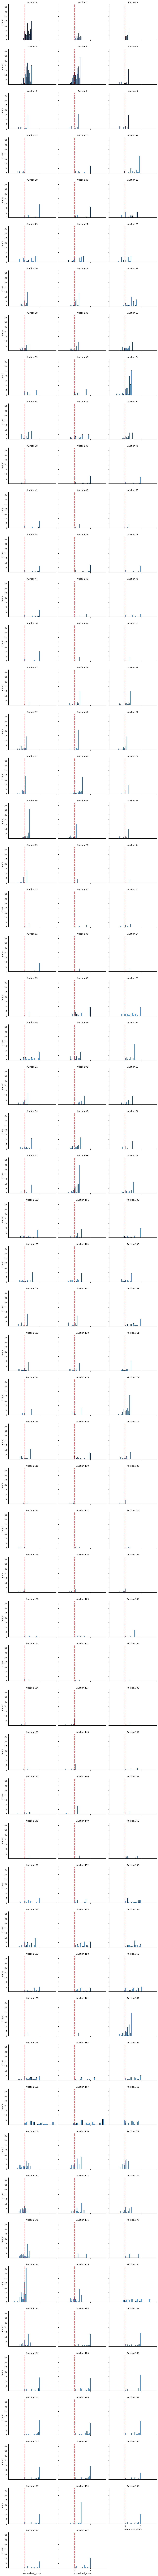

In [236]:
g = sns.FacetGrid(aux_df, col="auction_id", col_wrap=3, height=3, aspect=1.2)
g.map_dataframe(sns.histplot, x="normalized_score", bins=20)
g.set_titles("Auction {col_name}")

g.set(xlim=(lower_bound, upper_bound))  # Set xlim for all plots

# Add a vertical line for the threshold per facet
for ax, auction_id in zip(g.axes.flatten(), g.col_names):
    ax.axvline(0, color="red", linestyle="--")

    # Adjust x-axis to the range of the data
    data = aux_df.loc[final_df["auction_id"] == auction_id, "normalized_score"]

    ax.set_xticks(plt.MaxNLocator(integer=True).tick_values(data.min(), data.max()))

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'competitiveauctions_normalizedscore_histogram2.png'))

plt.show()
